# Machine Learning Race Predictor
## Supervised Learning - Regression

## Data Preparation:

First we load the raw data that was gathered from thousands of users' public training logs. These contained training data as well as race results.

In [62]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import datetime
import time

# Pretty display for notebooks
%matplotlib inline

# Display a description of the dataset
pd.set_option('display.max_columns', 500)

# Load the wholesale customers dataset
try:
    all_data = pd.read_csv("../data.csv")
    print "Running dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"
    
data = all_data[['5K','10K','half','marathon']].dropna()
data.reset_index(drop=True, inplace=True)


x = time.strptime('2:24:31','%H:%M:%S')
seconds = datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
print seconds

def timeToSeconds(t):
    t = t.split('.')[0]
    try:
        x = time.strptime(t,'%H:%M:%S')
        return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
    except:
        x = time.strptime(t,'%M:%S')
        return datetime.timedelta(minutes=x.tm_min,seconds=x.tm_sec).total_seconds()

data = data.applymap(lambda x: timeToSeconds(x))

#data['distance'] = data['distance'].map(lambda x: x.split(" ")[0])
display(data.describe())

Running dataset has 771 samples with 4 features each.
8671.0


,5K,10K,half,marathon
count,771.000000,771.000000,771.000000,771.000000
mean,1315.866407,2797.118029,6440.249027,15105.595331
std,281.765245,567.445376,1388.323670,4237.855744
min,66.000000,351.000000,822.000000,2135.000000
25%,1163.000000,2463.500000,5534.500000,12539.500000
50%,1297.000000,2746.000000,6246.000000,14273.000000
75%,1451.500000,3068.500000,7038.000000,16748.000000
max,2993.000000,6684.000000,15471.000000,43920.000000


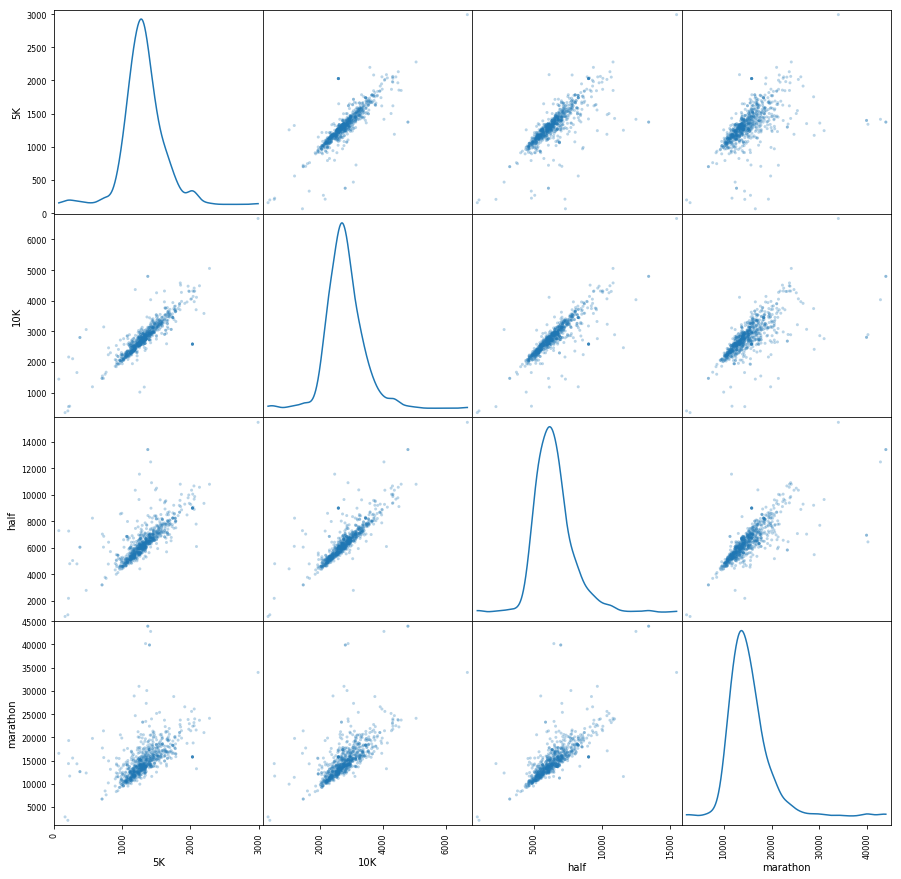

In [63]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (15,15), diagonal = 'kde');

In [64]:
feature_sets = {} 
outliers = []
for feature in data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(data[feature], 25)
    print Q1
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(data[feature], 75)
    print Q3
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Outliers
    feature_outliers = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
    
    print "feature_outliers.index.values: ", feature_outliers.index.values.tolist()
    outliers += feature_outliers.index.values.tolist()
    # Add to feature set
    feature_sets[feature] = set(feature_outliers.index.values)
    print feature_sets
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(feature_outliers)

1163.0
1451.5
feature_outliers.index.values:  [14, 22, 44, 124, 142, 154, 181, 190, 216, 218, 228, 294, 295, 314, 326, 331, 379, 381, 394, 401, 468, 470, 481, 501, 508, 539, 549, 553, 555, 572, 580, 597, 609, 621, 658, 660, 667, 668, 732, 744, 747, 767]
{'5K': set([394, 14, 401, 658, 660, 22, 154, 539, 668, 767, 667, 549, 294, 295, 553, 555, 44, 181, 314, 572, 190, 580, 326, 609, 331, 468, 142, 470, 216, 218, 732, 481, 228, 744, 508, 747, 621, 501, 379, 124, 381, 597])}
Data points considered outliers for the feature '5K':


,5K,10K,half,marathon
14,2029.0,2586.0,9001.0,15783.0
22,2088.0,4113.0,6100.0,13235.0
44,2029.0,2586.0,9001.0,15783.0
124,376.0,2802.0,6050.0,12611.0
142,2029.0,2586.0,9001.0,15783.0
154,376.0,2802.0,6050.0,12611.0
181,269.0,2109.0,5043.0,15540.0
190,722.0,1467.0,6054.0,21387.0
216,2029.0,2586.0,9001.0,15783.0
218,199.0,407.0,948.0,2135.0


2463.5
3068.5
feature_outliers.index.values:  [22, 190, 218, 228, 294, 309, 310, 314, 317, 326, 333, 381, 401, 447, 468, 508, 515, 555, 577, 580, 589, 591, 597, 609, 621, 645, 658, 660, 667, 668, 732, 744, 746, 747, 767, 769]
{'10K': set([769, 515, 645, 401, 658, 660, 22, 667, 668, 294, 555, 309, 310, 314, 317, 190, 447, 577, 580, 326, 333, 589, 468, 597, 218, 591, 732, 609, 228, 744, 746, 747, 621, 508, 381, 767]), '5K': set([394, 14, 401, 658, 660, 22, 154, 539, 668, 767, 667, 549, 294, 295, 553, 555, 44, 181, 314, 572, 190, 580, 326, 609, 331, 468, 142, 470, 216, 218, 732, 481, 228, 744, 508, 747, 621, 501, 379, 124, 381, 597])}
Data points considered outliers for the feature '10K':


,5K,10K,half,marathon
22,2088.0,4113.0,6100.0,13235.0
190,722.0,1467.0,6054.0,21387.0
218,199.0,407.0,948.0,2135.0
228,208.0,547.0,2192.0,14342.0
294,2033.0,4318.0,10051.0,22386.0
309,1321.0,1184.0,6115.0,11385.0
310,1502.0,4260.0,10503.0,25142.0
314,1965.0,4476.0,9775.0,23831.0
317,1256.0,1020.0,4416.0,9922.0
326,226.0,561.0,4802.0,11663.0


5534.5
7038.0
feature_outliers.index.values:  [17, 218, 228, 294, 310, 314, 331, 333, 381, 429, 468, 481, 508, 511, 515, 549, 577, 589, 597, 609, 621, 645, 650, 658, 660, 662, 668, 732, 733, 739, 744, 746, 748, 767, 769]
{'10K': set([769, 515, 645, 401, 658, 660, 22, 667, 668, 294, 555, 309, 310, 314, 317, 190, 447, 577, 580, 326, 333, 589, 468, 597, 218, 591, 732, 609, 228, 744, 746, 747, 621, 508, 381, 767]), '5K': set([394, 14, 401, 658, 660, 22, 154, 539, 668, 767, 667, 549, 294, 295, 553, 555, 44, 181, 314, 572, 190, 580, 326, 609, 331, 468, 142, 470, 216, 218, 732, 481, 228, 744, 508, 747, 621, 501, 379, 124, 381, 597]), 'half': set([769, 515, 645, 650, 17, 658, 660, 662, 668, 549, 294, 429, 310, 314, 577, 609, 331, 333, 589, 468, 597, 218, 732, 733, 481, 739, 228, 744, 746, 748, 621, 767, 508, 381, 511])}
Data points considered outliers for the feature 'half':


,5K,10K,half,marathon
17,1428.0,2892.0,10914.0,23961.0
218,199.0,407.0,948.0,2135.0
228,208.0,547.0,2192.0,14342.0
294,2033.0,4318.0,10051.0,22386.0
310,1502.0,4260.0,10503.0,25142.0
314,1965.0,4476.0,9775.0,23831.0
331,1916.0,3915.0,9297.0,26565.0
333,1373.0,4796.0,13416.0,43920.0
381,701.0,1469.0,3204.0,6717.0
429,1485.0,3233.0,10372.0,17088.0


12539.5
16748.0
feature_outliers.index.values:  [2, 17, 120, 121, 168, 182, 218, 277, 310, 314, 331, 333, 341, 450, 508, 511, 515, 553, 577, 589, 596, 597, 621, 645, 658, 660, 668, 741, 744, 746, 754]
{'10K': set([769, 515, 645, 401, 658, 660, 22, 667, 668, 294, 555, 309, 310, 314, 317, 190, 447, 577, 580, 326, 333, 589, 468, 597, 218, 591, 732, 609, 228, 744, 746, 747, 621, 508, 381, 767]), 'marathon': set([2, 515, 645, 341, 17, 658, 660, 277, 668, 168, 553, 310, 314, 577, 450, 182, 331, 333, 589, 596, 597, 218, 741, 744, 746, 621, 754, 120, 121, 508, 511]), '5K': set([394, 14, 401, 658, 660, 22, 154, 539, 668, 767, 667, 549, 294, 295, 553, 555, 44, 181, 314, 572, 190, 580, 326, 609, 331, 468, 142, 470, 216, 218, 732, 481, 228, 744, 508, 747, 621, 501, 379, 124, 381, 597]), 'half': set([769, 515, 645, 650, 17, 658, 660, 662, 668, 549, 294, 429, 310, 314, 577, 609, 331, 333, 589, 468, 597, 218, 732, 733, 481, 739, 228, 744, 746, 748, 621, 767, 508, 381, 511])}
Data points considered ou

,5K,10K,half,marathon
2,1343.0,2900.0,6462.0,23424.0
17,1428.0,2892.0,10914.0,23961.0
120,1173.0,2415.0,5485.0,28900.0
121,1358.0,2861.0,7701.0,30067.0
168,1298.0,2684.0,5837.0,23266.0
182,1350.0,3068.0,7035.0,27307.0
218,199.0,407.0,948.0,2135.0
277,1340.0,2895.0,6449.0,40169.0
310,1502.0,4260.0,10503.0,25142.0
314,1965.0,4476.0,9775.0,23831.0


In [65]:
# drop outliers
data = data.drop(data.index[outliers]).reset_index(drop = True)

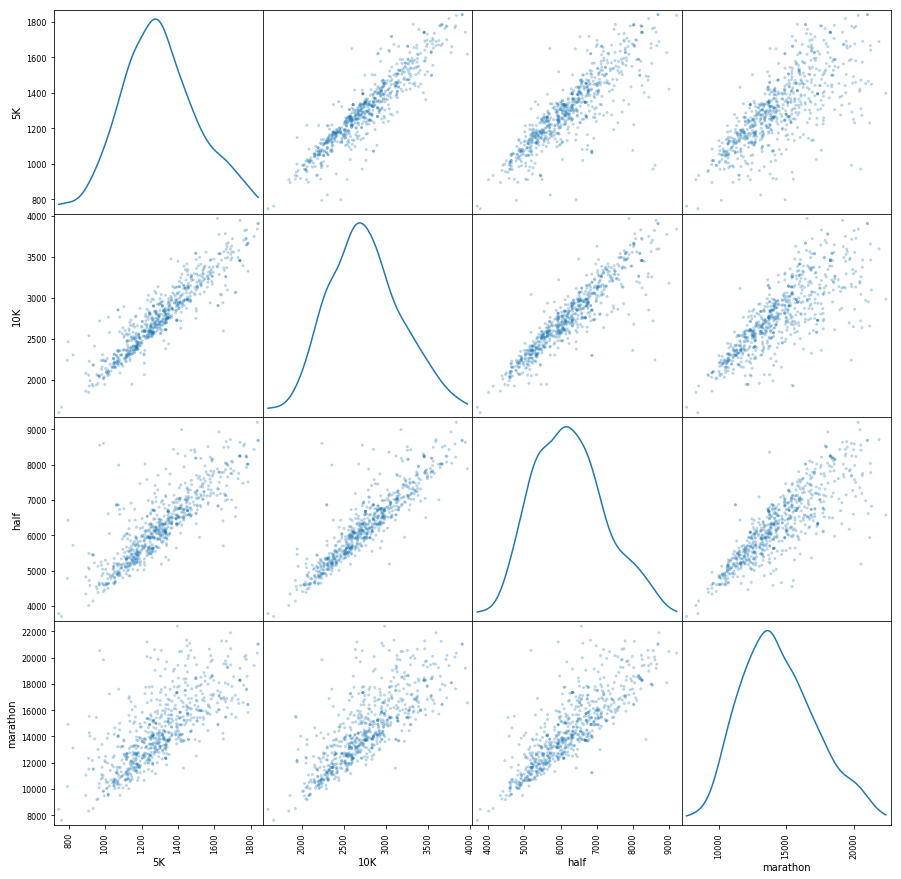

In [66]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (15,15), diagonal = 'kde');

In [67]:
# Split the data into features and target label
y = data['marathon']
x = data.drop('marathon', axis = 1)

In [69]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 558 samples.
Testing set has 140 samples.


In [135]:
## Using the old runner's world formula as a benchmark
# T2=T1*(D2/D1)^1.06

d1 = 5000 #5K
d2 = 42195 #Marathon in meters

def riegel(t1):
    return t1 * (d2/d1)**1.06

def secondsToTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

riegel_y = x[["5K"]].applymap(lambda x: riegel(x))
riegel_y.rename(columns = {'5K':'marathon_pred'}, inplace=True)

compare = pd.concat([x["5K"], riegel_y, y], axis=1)
compare.rename(columns = {'marathon':'marathon_true'}, inplace=True)
compare = compare.sort_values(by=['5K'])
percent_off = abs(100 * (compare['marathon_pred'] - compare['marathon_true'])/compare['marathon_true'])

print 'Average percent off {0:.2f}%'.format(percent_off.mean())
print 'Average actual marathon time {}'.format(secondsToTime(compare['marathon_true'].mean()))
print 'Average predicted marathon time {}'.format(secondsToTime(compare['marathon_pred'].mean()))
percent_off = percent_off.map(lambda x: "{0:.2f}%".format(x))
    
compare = compare.applymap(lambda x: secondsToTime(x))
compare = pd.concat([compare, percent_off], axis=1)



display(compare)


Average percent off 17.27%
Average actual marathon time 4:00:42
Average predicted marathon time 3:16:51


,5K,marathon_pred,marathon_true,0
516,0:12:26,1:52:41,2:20:54,20.03%
280,0:12:41,1:54:56,2:06:53,9.41%
138,0:13:13,1:59:47,2:49:45,29.44%
414,0:13:17,2:00:23,4:08:39,51.58%
632,0:13:44,2:04:27,3:38:38,43.07%
25,0:14:54,2:15:02,2:38:23,14.74%
130,0:14:55,2:15:11,3:04:17,26.64%
633,0:15:10,2:17:27,2:18:34,0.80%
650,0:15:10,2:17:27,3:25:44,33.19%
636,0:15:11,2:17:36,3:11:54,28.29%


### Riegel's Unrealistic formula

As you can see from the chart below, the current age old formula is terrible at predicting marathon results from 5K times. Out of almost 700 data points, all but about a dozen are above the line meaning the marathon time predicted is unatainable for your average runner.

Without even providing any other features, it would already be easy to vastly improve on this formula from doing a simple linear regression. Let's do that and see!

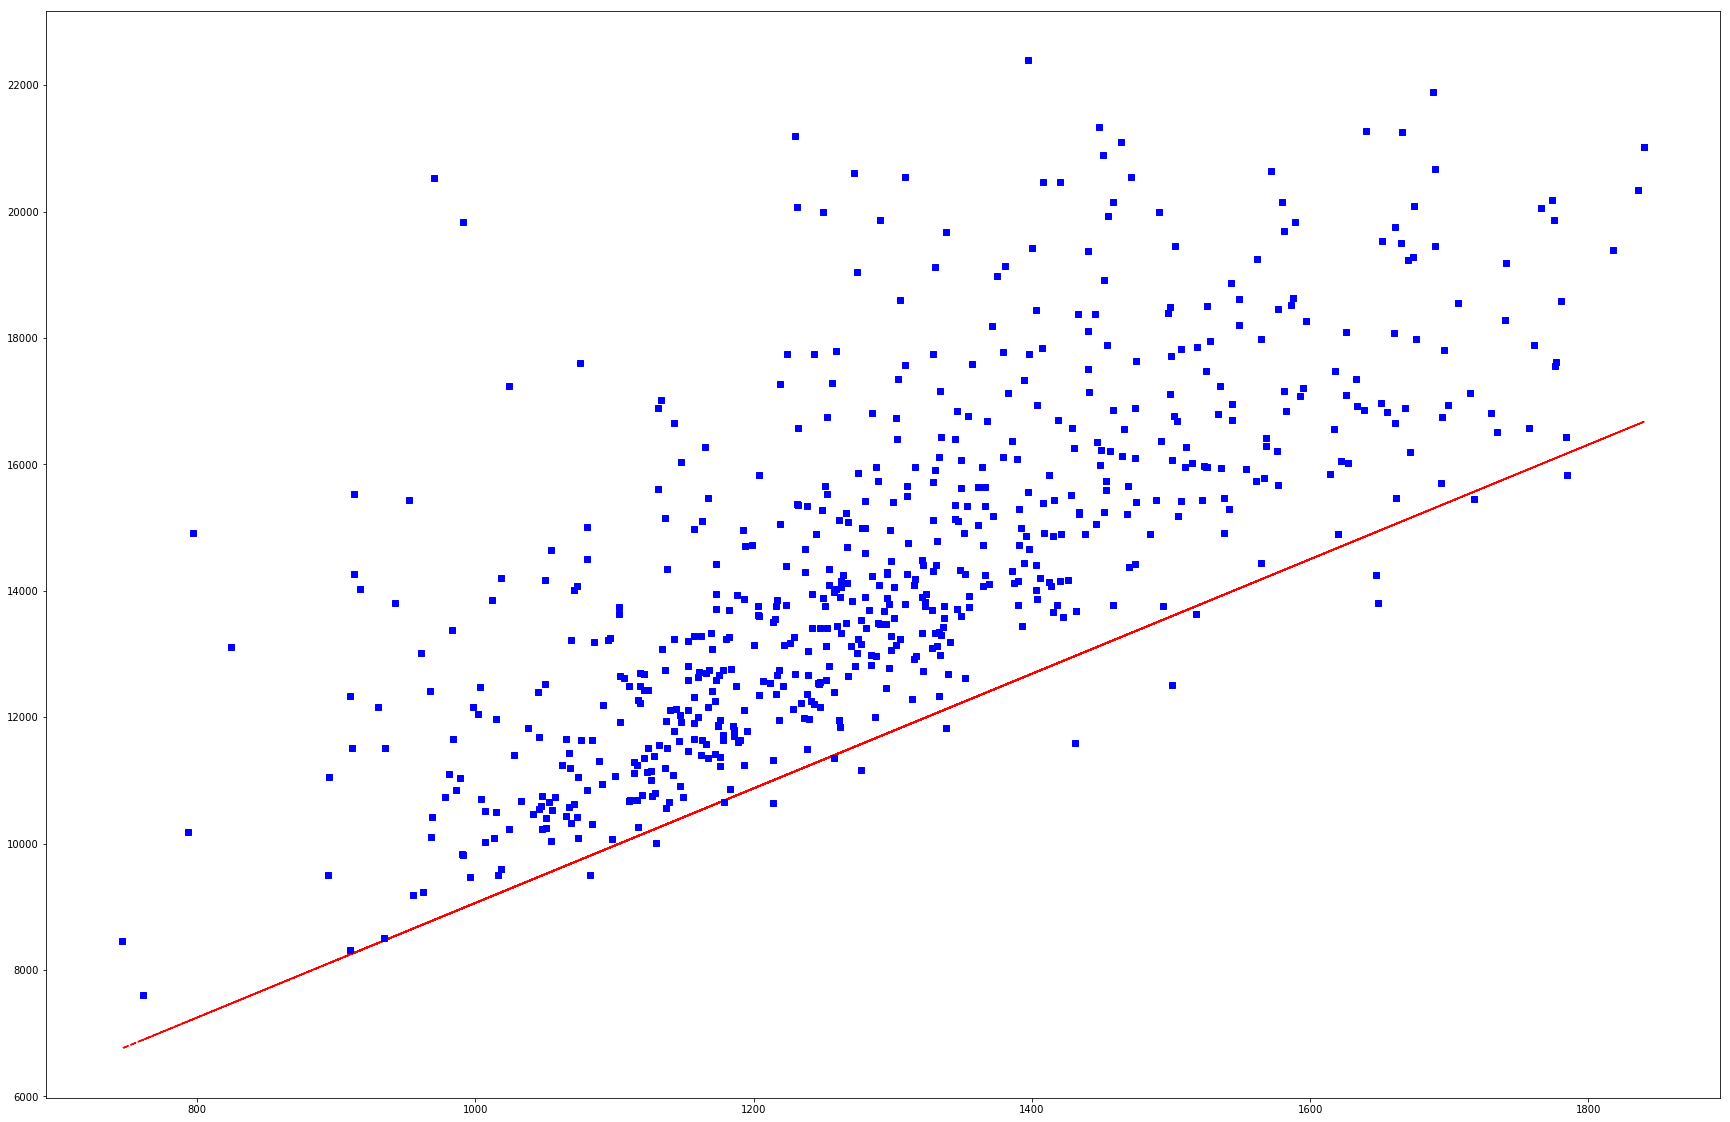

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# red dashes, blue squares and green triangles
plt.figure(figsize=(30,20))
plt.plot(x['5K'], riegel_y, 'r--', x['5K'], y, 'bs')
plt.show()